<a href="https://colab.research.google.com/github/deepu-san/Projects/blob/main/Chennai%20House%20Price%20Prediction/Chennai_House_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from scipy import stats


Loading the CSV file

In [ ]:
path="https://raw.githubusercontent.com/deepu-san/Projects/main/Chennai%20House%20Price%20Prediction/train-chennai-sale.csv"
df = pd.read_csv(path)
df.head(3)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,...,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,...,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,...,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200


# Data Cleaning

In [ ]:
df[df.duplicated()]

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE


Here we checked if there were any duplicate data points. Since it returned an empty data frame, we can conclude that there are no duplicates in the data.

Now we have to check the data types of the features.


In [ ]:
df.dtypes

PRT_ID            object
AREA              object
INT_SQFT           int64
DATE_SALE         object
DIST_MAINROAD      int64
N_BEDROOM        float64
N_BATHROOM       float64
N_ROOM             int64
SALE_COND         object
PARK_FACIL        object
DATE_BUILD        object
BUILDTYPE         object
UTILITY_AVAIL     object
STREET            object
MZZONE            object
QS_ROOMS         float64
QS_BATHROOM      float64
QS_BEDROOM       float64
QS_OVERALL       float64
REG_FEE            int64
COMMIS             int64
SALES_PRICE        int64
dtype: object

Here as we can see  'DATE_SALE' and 'DATE_BUILD' are present as string/objects. We are going to convert them to date-time objects and then create another feature called 'AGE', which might be a influential feature. 

In [ ]:
df['DATE_SALE'] = pd.to_datetime(df['DATE_SALE'],format='%d-%m-%Y', errors='coerce')
df['DATE_BUILD'] = pd.to_datetime(df['DATE_BUILD'],format='%d-%m-%Y', errors='coerce')
df["AGE"]=(df["DATE_SALE"]-df["DATE_BUILD"])/np.timedelta64(1, 'Y') #gives us the AGE in temrs of years

Now we can drop unwanted featues from the dataframe.

In [ ]:
df.drop(["DATE_SALE","DATE_BUILD","PRT_ID","REG_FEE","COMMIS","QS_ROOMS","QS_BATHROOM","QS_BEDROOM","QS_OVERALL"],axis=1,inplace=True)


Next we have to check if there are any null/Nan values in the dataframe and then deal with it.

In [ ]:
df.isna().sum()

AREA             0
INT_SQFT         0
DIST_MAINROAD    0
N_BEDROOM        1
N_BATHROOM       5
N_ROOM           0
SALE_COND        0
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
MZZONE           0
SALES_PRICE      0
AGE              0
dtype: int64

In [ ]:
df.corr()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALES_PRICE,AGE
INT_SQFT,1.000000,0.002022,0.786348,0.515390,0.951279,0.612125,-0.012776
DIST_MAINROAD,0.002022,1.000000,-0.002566,0.001970,0.002301,0.018783,-0.003588
N_BEDROOM,0.786348,-0.002566,1.000000,0.755214,0.840286,0.330999,-0.045950
N_BATHROOM,0.515390,0.001970,0.755214,1.000000,0.568688,0.108884,-0.020130
N_ROOM,0.951279,0.002301,0.840286,0.568688,1.000000,0.602760,-0.033448
SALES_PRICE,0.612125,0.018783,0.330999,0.108884,0.602760,1.000000,-0.119037
AGE,-0.012776,-0.003588,-0.045950,-0.020130,-0.033448,-0.119037,1.000000


From the correlation data we can see that 'N_BEDROOM' and 'N_BATHROOM' have good correlation with the feature 'N_ROOM', hence we can try to fill the null values using this information.

In [ ]:
df['N_BEDROOM'] = df.groupby('N_ROOM')['N_BEDROOM'].apply(lambda x:x.fillna(x.median()))
df['N_BATHROOM'] = df.groupby('N_ROOM')['N_BATHROOM'].apply(lambda x:x.fillna(x.median()))

In the case of null value in the feature 'N_BEDROOM', we first look at the 'N_ROOM' feature (which is the number of rooms). Then we take the median value of 'N_BEDROOM' with that specific number of rooms and then use this value to fill the nan/null values. This was also done for missing values in 'N_BATHROOM'.

In [ ]:
df.isna().sum()

AREA             0
INT_SQFT         0
DIST_MAINROAD    0
N_BEDROOM        0
N_BATHROOM       0
N_ROOM           0
SALE_COND        0
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
MZZONE           0
SALES_PRICE      0
AGE              0
dtype: int64

Corercting Spelling Mistakes in Data


In [ ]:
df['AREA'].unique()

array(['Karapakkam', 'Anna Nagar', 'Adyar', 'Velachery', 'Chrompet',
       'KK Nagar', 'TNagar', 'T Nagar', 'Chrompt', 'Chrmpet', 'Karapakam',
       'Ana Nagar', 'Chormpet', 'Adyr', 'Velchery', 'Ann Nagar',
       'KKNagar'], dtype=object)

In [ ]:
df['AREA'].value_counts()

Chrompet      1681
Karapakkam    1363
KK Nagar       996
Velachery      979
Anna Nagar     783
Adyar          773
T Nagar        496
Chrompt          9
Chrmpet          6
Chormpet         6
TNagar           5
Karapakam        3
Ana Nagar        3
Velchery         2
Ann Nagar        2
Adyr             1
KKNagar          1
Name: AREA, dtype: int64

In [ ]:
df["AREA"] = df["AREA"].replace({"Chrompt" : "Chrompet", "Chrmpet" : "Chrompet","Chormpet":"Chrompet","TNagar":"T Nagar","Karapakam":"Karapakkam",
                                "Ana Nagar":"Anna Nagar","Velchery":"Velachery","Ann Nagar":"Anna Nagar","Adyr":"Adyar","KKNagar":"KK Nagar"})

In [ ]:
df['SALE_COND'].unique()

array(['AbNormal', 'Family', 'Partial', 'AdjLand', 'Normal Sale',
       'Ab Normal', 'Partiall', 'Adj Land', 'PartiaLl'], dtype=object)

In [ ]:
df["SALE_COND"] = df["SALE_COND"].replace({"Adj Land" : "AdjLand", "Ab Normal" : "AbNormal","Partiall":"Partial","PartiaLl":"Partial"})

In [ ]:
df['PARK_FACIL'].unique()

array(['Yes', 'No', 'Noo'], dtype=object)

In [ ]:
df["PARK_FACIL"] = df["PARK_FACIL"].replace({"Noo" : "No"})


In [ ]:
df["BUILDTYPE"].unique()

array(['Commercial', 'Others', 'Other', 'House', 'Comercial'],
      dtype=object)

In [ ]:
df["BUILDTYPE"] = df["BUILDTYPE"].replace({"Other" : "Others","Comercial":"Commercial"})


In [ ]:
df['UTILITY_AVAIL'].unique()

array(['AllPub', 'ELO', 'NoSewr ', 'NoSeWa', 'All Pub'], dtype=object)

In [ ]:
df["UTILITY_AVAIL"] = df["UTILITY_AVAIL"].replace({"NoSewr " : "NoSewr","All Pub":"AllPub"})

In [ ]:
df['STREET'].unique()

array(['Paved', 'Gravel', 'No Access', 'Pavd', 'NoAccess'], dtype=object)

In [ ]:
df["STREET"] = df["STREET"].replace({"Pavd" : "Paved","NoAccess":"No Access"})


In [ ]:
df['MZZONE'].unique()

array(['A', 'RH', 'RL', 'I', 'C', 'RM'], dtype=object)

In [ ]:
# df["SALE_COND"] = df["SALE_COND"].replace({"Adj Land" : "AdjLand", "Ab Normal" : "AbNormal","Partiall":"Partial","PartiaLl":"Partial"})

# df["PARK_FACIL"] = df["PARK_FACIL"].replace({"Noo" : "No"})

# df["BUILDTYPE"] = df["BUILDTYPE"].replace({"Other" : "Others","Comercial":"Commercial"})

# df["UTILITY_AVAIL"] = df["UTILITY_AVAIL"].replace({"NoSewr " : "NoSewr","All Pub":"AllPub"})

# df["STREET"] = df["STREET"].replace({"Pavd" : "Paved","NoAccess":"No Access"})


In [ ]:
df.describe()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALES_PRICE,AGE
count,7109.000000,7109.000000,7109.000000,7109.000000,7109.000000,7.109000e+03,7109.000000
mean,1382.073006,99.603179,1.637080,1.213251,3.688704,1.089491e+07,24.275615
std,457.410902,57.403110,0.802857,0.409632,1.019099,3.768603e+06,12.333812
min,500.000000,0.000000,1.000000,1.000000,2.000000,2.156875e+06,3.997344
25%,993.000000,50.000000,1.000000,1.000000,3.000000,8.272100e+06,13.990705
50%,1373.000000,99.000000,1.000000,1.000000,4.000000,1.033505e+07,22.984729
75%,1744.000000,148.000000,2.000000,1.000000,4.000000,1.299390e+07,33.977426
max,2500.000000,200.000000,4.000000,2.000000,6.000000,2.366734e+07,54.963483


From this we can see that the data does not contain may outliers

# EDA 

Distribution plots for numerical features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


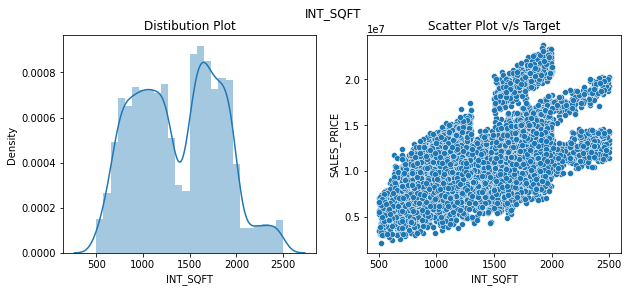

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('INT_SQFT')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["INT_SQFT"],ax=axes[0])
sns.scatterplot(data=df, x="INT_SQFT", y="SALES_PRICE")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


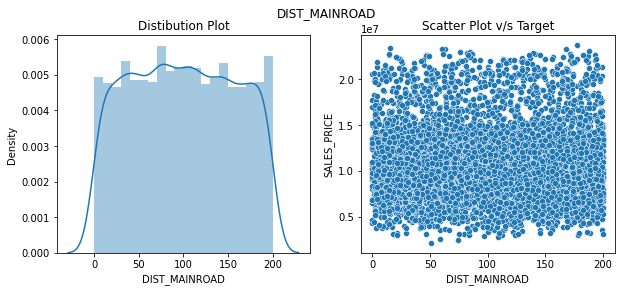

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('DIST_MAINROAD')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["DIST_MAINROAD"],ax=axes[0])
sns.scatterplot(data=df, x="DIST_MAINROAD", y="SALES_PRICE")


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


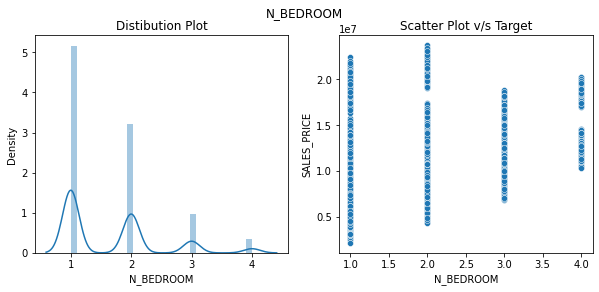

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_BEDROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["N_BEDROOM"],ax=axes[0])
sns.scatterplot(data=df, x="N_BEDROOM", y="SALES_PRICE")


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


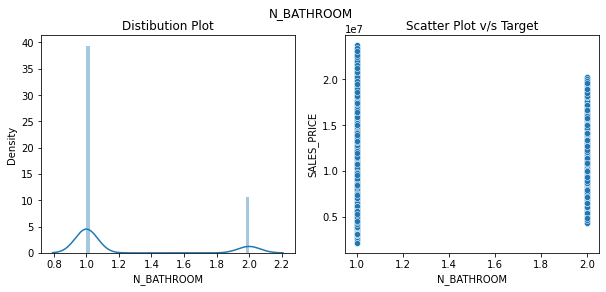

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_BATHROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["N_BATHROOM"],ax=axes[0])
sns.scatterplot(data=df, x="N_BATHROOM", y="SALES_PRICE")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


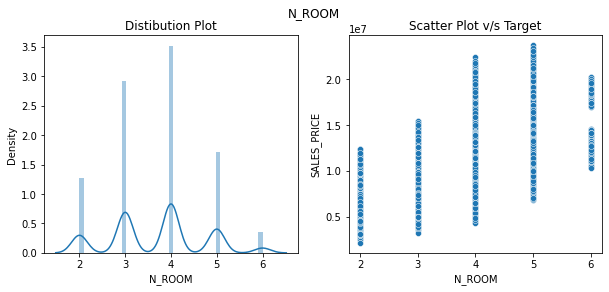

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_ROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["N_ROOM"],ax=axes[0])
sns.scatterplot(data=df, x="N_ROOM", y="SALES_PRICE")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


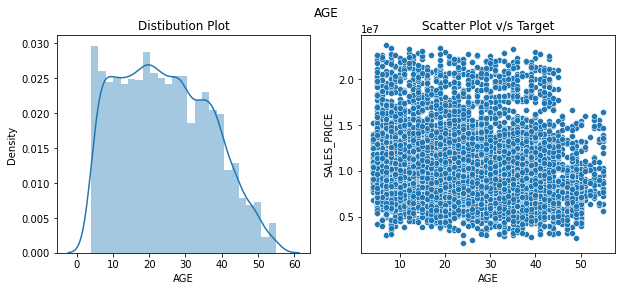

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('AGE')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["AGE"],ax=axes[0])
sns.scatterplot(data=df, x="AGE", y="SALES_PRICE")

Distribution Plot for Categorical Features

In [ ]:
df.columns

Index(['AREA', 'INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM',
       'N_ROOM', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL',
       'STREET', 'MZZONE', 'SALES_PRICE', 'AGE'],
      dtype='object')

Text(0, 0.5, 'Sales Price Avg')

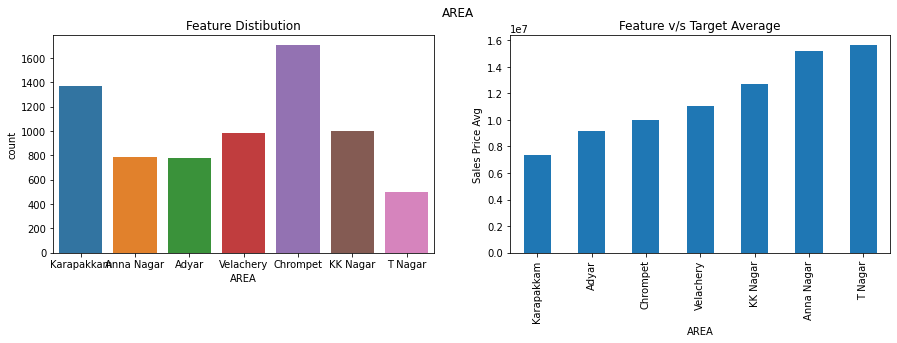

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('AREA')

axes[0].set_title('Feature Distibution')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="AREA", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("AREA")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["AREA"] = df["AREA"].replace({"Karapakkam" : 0,"Adyar":1,"Chrompet":2,"Velachery":3,"KK Nagar":4,"Anna Nagar":5,"T Nagar":6})

Text(0, 0.5, 'Sales Price Avg')

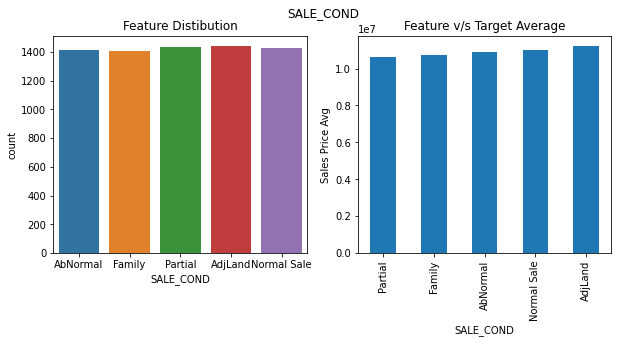

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('SALE_COND')

axes[0].set_title('Feature Distibution')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="SALE_COND", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("SALE_COND")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["SALE_COND"].unique()

array(['AbNormal', 'Family', 'Partial', 'AdjLand', 'Normal Sale'],
      dtype=object)

In [ ]:
df["SALE_COND"] = df["SALE_COND"].replace({"Partial" : 0,"Family":1,"AbNormal":2,"Normal Sale":3,"AdjLand":4})

Text(0, 0.5, 'Sales Price Avg')

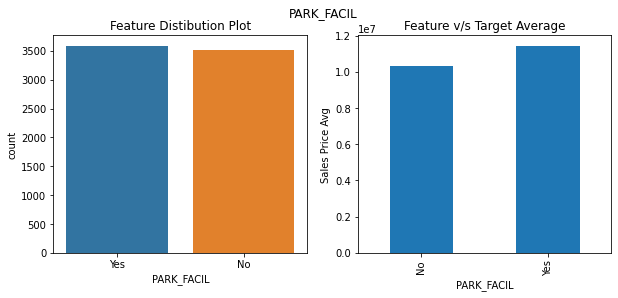

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('PARK_FACIL')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="PARK_FACIL", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("PARK_FACIL")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["PARK_FACIL"] = df["PARK_FACIL"].replace({"No" : 0,"Yes":1})

Text(0, 0.5, 'Sales Price Avg')

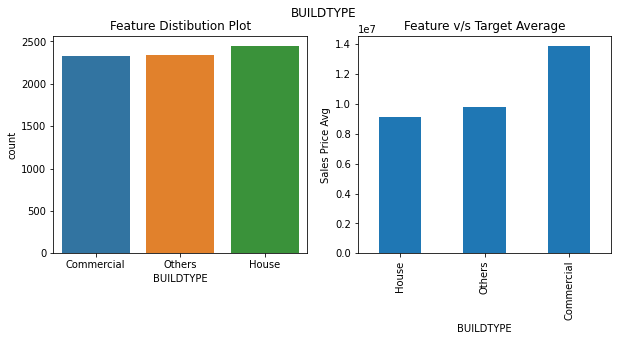

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('BUILDTYPE')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="BUILDTYPE", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("BUILDTYPE")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

Text(0, 0.5, 'Sales Price Avg')

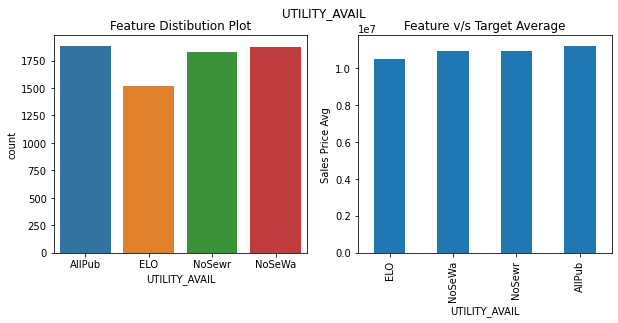

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('UTILITY_AVAIL')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="UTILITY_AVAIL", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("UTILITY_AVAIL")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["UTILITY_AVAIL"] = df["UTILITY_AVAIL"].replace({"ELO" : 0,"NoSeWa":1,"NoSewr":2,"AllPub":3})

Text(0, 0.5, 'Sales Price Avg')

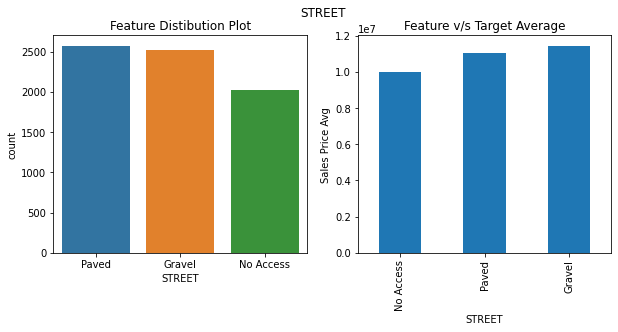

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('STREET')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="STREET", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("STREET")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["STREET"] = df["STREET"].replace({"No Access" : 0,"Paved":1,"Gravel":2})

Text(0, 0.5, 'Sales Price Avg')

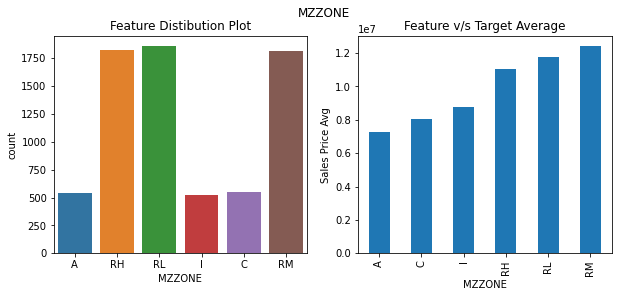

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('MZZONE')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')

sns.countplot(x="MZZONE", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("MZZONE")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Sales Price Avg")

In [ ]:
df["MZZONE"] = df["MZZONE"].replace({"A" : 0,"C":1,"I":2,"RH":3,"RL":4,"RM":5})

For the categorical features which we didn't label encode because of uncertainity of linear relationship with target, we get dummy variables.

In [ ]:
 df2 = pd.get_dummies(df,drop_first=True)
 df2.head(3)

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,UTILITY_AVAIL,STREET,MZZONE,SALES_PRICE,AGE,BUILDTYPE_House,BUILDTYPE_Others
0,0,1004,131,1.0,1.0,3,2,1,3,1,0,7600000,43.970787,0,0
1,5,1986,26,2.0,1.0,5,2,0,3,2,3,21717770,10.992697,0,0
2,1,909,70,1.0,1.0,3,2,1,0,2,4,13159200,19.986721,0,0


# Model Fitting

In [ ]:
target="SALES_PRICE"
X = df2.drop(target,axis=1) 
y = df2[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Linear Reg

In [ ]:
model = LinearRegression() 
model.fit(X_train,y_train) 

LinearRegression()

###Decision Tree Regressor

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train,y_train) 

DecisionTreeRegressor()

Feature Importance

In [ ]:
# from matplotlib import pyplot
# dt = DecisionTreeClassifier(max_depth = 2)
# dt.fit(X_train, y_train)
# importance = dt.feature_importances_
# #list(zip(importance,X_test.columns)) # it calculates the feature importances based on IG
# sorted(zip(importance,X_test.columns), reverse=True)[:3]


[(0.3380632180211761, 'SALE_COND'),
 (0.33311086030324355, 'INT_SQFT'),
 (0.32882592167558033, 'AREA')]

### Random Forest


In [ ]:
model = RandomForestRegressor(n_estimators= 100, max_depth = 3, max_features='sqrt')
model.fit(X_train,y_train) 

RandomForestRegressor(max_depth=5, max_features='sqrt')

### XG Boost

In [ ]:
for lr in [0.06,0.07,0.08,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.9]:
    model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
    model.fit(X_train,y_train) #train the model
    model.score(X_test, y_test) # scoring the model - r2 squared
    print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train, y_train, cv=10)))

Learning rate :  0.06  Train score :  0.970195905993764  Cross-Val score :  0.9677808714747064
Learning rate :  0.07  Train score :  0.9776351170775698  Cross-Val score :  0.9744607603720207
Learning rate :  0.08  Train score :  0.981135703599545  Cross-Val score :  0.9785856155858232
Learning rate :  0.1  Train score :  0.986816684482542  Cross-Val score :  0.9844079716085765
Learning rate :  0.2  Train score :  0.9931576797405699  Cross-Val score :  0.9914286821344609
Learning rate :  0.3  Train score :  0.9939865403940608  Cross-Val score :  0.9924101088467985
Learning rate :  0.4  Train score :  0.9955916362646998  Cross-Val score :  0.9939693872831274
Learning rate :  0.45  Train score :  0.9960942553151744  Cross-Val score :  0.9941020976108275
Learning rate :  0.5  Train score :  0.9949811484487929  Cross-Val score :  0.9935959884349295
Learning rate :  0.55  Train score :  0.9949554357618804  Cross-Val score :  0.9935672052112047
Learning rate :  0.9  Train score :  0.994599077

In [ ]:
model = xgb.XGBRegressor(learning_rate = 0.45, n_estimators=100)
model.fit(X_train,y_train) #train the model
model.score(X_test, y_test) # scoring the model - r2 squared

[05:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9947616514194225

# Prediction

In [ ]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluation

In [ ]:
print('Train R2-SCORE:', metrics.r2_score(y_train,y_train_pred))
print('Test R2-SCORE:', metrics.r2_score(y_test,y_test_pred))


Train R2-SCORE: 1.0
Test R2-SCORE: 0.9659966729719209


# Feature Importance

In [ ]:
from matplotlib import pyplot
dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)
importance = dt.feature_importances_
#list(zip(importance,X_test.columns)) # it calculates the feature importances based on IG

print("Top 5 Important Features and their importance :",*sorted(zip(importance,X_test.columns), reverse=True)[:5])


Top 5 Important Features and their importance : (0.3380632180211761, 'SALE_COND') (0.33311086030324355, 'INT_SQFT') (0.32882592167558033, 'AREA') (0.0, 'UTILITY_AVAIL') (0.0, 'STREET')


# Prediction Interval

In [ ]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #print(z_score)
#generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    #return lower, prediction, upper
    print("Predicted Price : {:.2f}\n Negotiable Range :{:.2f} to {:.2f}".format(prediction,lower,upper))
get_prediction_interval(y_test_pred[0], y_test,y_test_pred)


1.959963984540054
Predicted Price : 9850978.00
 Negotiable Range :9307821.91 to 10394134.09
